Objective : WAP to train and evaluate a Recurrent Neural Network using PyTorch Library to predict the next value in a time series dataset.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [65]:
df = pd.read_csv("/content/daily-minimum-temperatures-in-me.csv", nrows=3650)
df.rename(columns={'Daily minimum temperatures in Melbourne, Australia, 1981-1990': 'Temp'}, inplace=True)
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [66]:
scaler = MinMaxScaler()
df['Temp'] = scaler.fit_transform(df[['Temp']])

In [67]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 7

X, y = create_sequences(df['Temp'].values, seq_length)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (3640, 7)
Shape of y: (3640,)


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [75]:
class DeepRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DeepRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Output from the last time step
        return out

In [83]:
input_size = 1  # Only 1 feature (temperature)
hidden_size = 128  # Number of RNN units
num_layers = 4  # Number of RNN layers
output_size = 1  # Predicting 1 value (temperature)

In [84]:
model = DeepRNNModel(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Assuming X_train, y_train, X_test, y_test are already defined and prepared
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Reshape input data to match RNN input format (batch_size, seq_length, input_size)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Epoch [5/30], Loss: 0.0189
Epoch [10/30], Loss: 0.0149
Epoch [15/30], Loss: 0.0137
Epoch [20/30], Loss: 0.0115
Epoch [25/30], Loss: 0.0120
Epoch [30/30], Loss: 0.0113


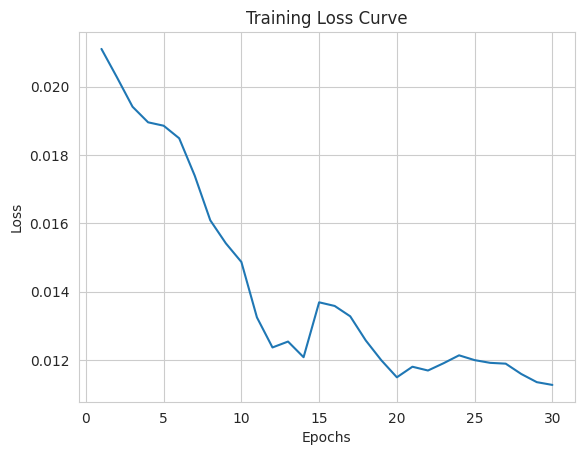

In [86]:
num_epochs = 30

# Store training losses
train_losses = []

for epoch in range(num_epochs):
    model.train()

    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)

    optimizer.zero_grad()  #
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Print the training loss for this epoch
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


plt.plot(range(1, 31), train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [87]:
model.eval()

with torch.no_grad():
    test_outputs = model(X_test)

# Calculate the test loss
test_loss = criterion(test_outputs.squeeze(), y_test)

# Print the test loss
print(f"Test Loss: {test_loss.item():.4f}")

predictions = scaler.inverse_transform(test_outputs.cpu().detach().numpy().reshape(-1, 1))
actual = scaler.inverse_transform(y_test.cpu().detach().numpy().reshape(-1, 1))

Test Loss: 0.0094


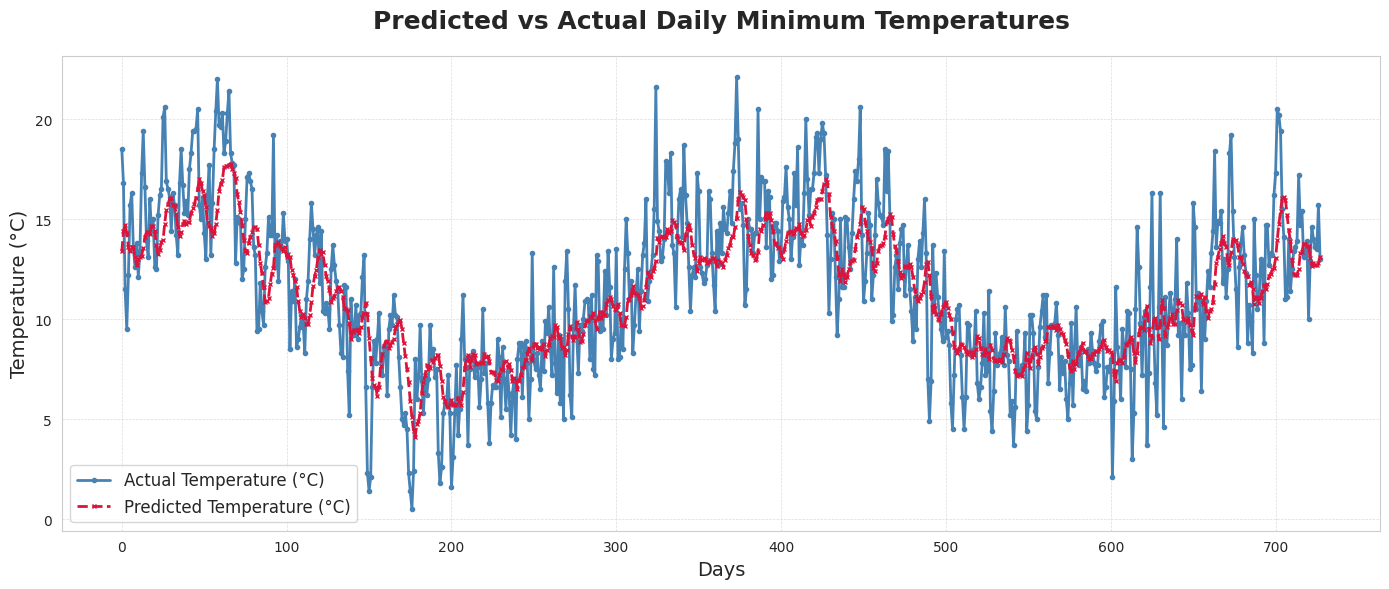

In [89]:
sns.set_style("whitegrid")

plt.figure(figsize=(14, 6))

# Plot actual values
plt.plot(actual_real, label='Actual Temperature (°C)', color='steelblue', linewidth=2, marker='o', markersize=3)

# Plot predicted values
plt.plot(predictions, label='Predicted Temperature (°C)', color='crimson', linewidth=2, linestyle='--', marker='x', markersize=3)
plt.title('Predicted vs Actual Daily Minimum Temperatures', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual_real, predictions)
rmse = np.sqrt(mean_squared_error(actual_real, predictions))

print(f'Mean Absolute Error (°C): {mae}')
print(f'Root Mean Squared Error (°C): {rmse}')

Mean Absolute Error (°C): 1.9927210807800293
Root Mean Squared Error (°C): 2.550545323722803


# Description of the Model

This project uses a Deep Recurrent Neural Network (RNN) to predict the daily minimum temperatures in Melbourne based on the past 7 days' temperature values.

The model:

  Takes a sequence of 7 days temperatures as input.    
  Uses a stacked RNN with 4 layers and 128 hidden units per layer.  
  Outputs the predicted temperature for the next day.   
  Uses Mean Squared Error (MSE) as the loss function and Adam optimizer for model training.

The RNN is trained for 30 epochs, and its performance is evaluated on unseen test data.

# Description of code


Libraries Imported:  
For data handling (pandas, numpy), visualization (matplotlib, seaborn), deep learning (torch), and evaluation (sklearn).

Data Loading & Preprocessing:  
Loaded temperature dataset, renamed columns, removed NaNs.  
Scaled temperature values between 0 and 1 using MinMaxScaler.

Sequence Preparation:  
Created sequences of the past 7 days as input and next day as target using a custom create_sequences function.

Train-Test Split:   
Split data into 80% training and 20% testing without shuffling.

Convert to Tensors:   
Converted data to PyTorch tensors and reshaped to match RNN input format (batch_size, seq_length, 1).

Model Definition:   
Defined a DeepRNNModel class with:  
4 RNN layers  
A fully connected layer for output.

Training Setup:   
Used MSELoss and Adam optimizer.  
Moved model and data to GPU/CPU.

Model Training:   
Trained for 30 epochs, calculated loss, and updated weights.   
Plotted the training loss curve.

Model Evaluation:   
Made predictions on test data, computed test loss, MAE, RMSE, and inverse-scaled results.

Visualization:   
Plotted actual vs predicted temperatures with clear styling and labels.

# My Comments  
RNNs is not good with longer dependencies and patterns.   
Switching to LSTM or GRU could improve the performance of model.  
we can experiment with different sequence lengths like  14, 30 days to see which captures patterns better